Last May, HBO released "Chernobyl" a historical miniseries (just 5 episodes) based on the events of the [Chernobyl nuclear disaster](https://en.wikipedia.org/wiki/Chernobyl_nuclear_disaster).

The show received widespread attention and was source of controversy. Suddenly, my twitter timeline was swarmed with tweets about Chernobyl (the tv show), about the nuclear incident, about the city/country/USSR, etc.

I wanted to see how realistic was that impact, or was just the result of my own "echo chamber". A quick Google Trends search found an obvious increase in Google searches: 

![image](https://user-images.githubusercontent.com/872296/60043644-edc6cb80-9696-11e9-9b33-4e362e3da5bd.png)

But, how meaningful was it? Did it spark a real worldwide controversy, as sources were claiming? How much impact did it have?

So then I thought, why not use Wikipedia to see how much impact the series had had? My reasoning was that, if it really caused a lot of controversy, people would rush to check facts and improve the articles to reflect responses to those controversies.

The page that I selected is **[Chernobyl nuclear disaster](https://en.wikipedia.org/wiki/Chernobyl_nuclear_disaster)**, the one describing the real event, the reactor explosion and aftermath.

In [1]:
import itertools
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

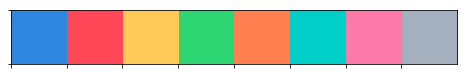

In [2]:
flatui = ["#2e86de", "#ff4757", "#feca57", "#2ed573", "#ff7f50", "#00cec9", "#fd79a8", "#a4b0be"]
flatui_palette = sns.color_palette(flatui)
sns.palplot(flatui_palette)
sns.set_palette(flatui_palette)

sns.set_style("darkgrid", {
    'axes.edgecolor': '#2b2b2b',
    'axes.facecolor': '#2b2b2b',
    'axes.labelcolor': '#919191',
    'figure.facecolor': '#2b2b2b',
    'grid.color': '#545454',
    'patch.edgecolor': '#2b2b2b',
    'text.color': '#bababa',
    'xtick.color': '#bababa',
    'ytick.color': '#bababa'
})

### Pulling the data from Wikipedia

Wikipedia's API is provided by the "wiki engine" powering Wikipedia itself, [MediaWiki](https://en.wikipedia.org/wiki/MediaWiki). The API works on top of HTTP but it's NOT RESTful; it's actually not so pretty. It took some time to understand. The "endpoint" we need to use to get revisions of a page is [`API:Revisions`](https://www.mediawiki.org/wiki/API:Revisions). Here's a quick example:

In [3]:
page_title = 'Chernobyl_disaster'

In [4]:
url = "https://en.wikipedia.org/w/api.php"

params = {
    "action": "query",
    "prop": "revisions",
    "titles": page_title,
    "rvprop": 'timestamp|flags|user|comment|size',
    "rvslots": "main",
    "formatversion": "2",
    'rvlimit': 500,   
    "format": 'json',
}

In [5]:
resp = requests.get(url, params=params)

In [6]:
doc = resp.json()

In [7]:
doc.keys()

dict_keys(['continue', 'query'])

The revisions of the page are nested under the `revisions` key for each `page` returned by the `query`. This is the last Revision of the page:

In [8]:
doc['query']['pages'][0]['revisions'][0]

{'minor': False,
 'user': 'Fsikkema',
 'timestamp': '2019-10-06T11:52:11Z',
 'size': 258254,
 'comment': 'corrected mortality rate to reflect UNSCEAR report'}

Which coincides with the last revision shown in the page:

![image](https://user-images.githubusercontent.com/872296/60045312-f7eac900-969a-11e9-8bd5-4f9f4da0255c.png)

*Note: you can check all the revisions with [this link](https://en.wikipedia.org/w/index.php?title=Chernobyl_disaster&action=history) (note that it might be outdated).*


#### Building a function

As we always recommend our students, the best thing to do is build functions that encapsulate the functionality that we need. In this case I'll build a function that acts as a "generator", which will pull all the revisions from Wikipedia. 

**IMPORTANT:** Keep in mind that there are can be hundred of thousands of revisions for a single page. Each request returns 500 records, so that'd need multiple hundred of requests to the Wikipedia API. That's why I've added a parameter `from_ts` to get revisions only starting from that given date. In my case, I only care about revisions from 2019, so my `from_ts` is equals to `2019-01-01T00:00:00`.

In [9]:
def get_all_revisions(page_title, props='timestamp|flags|user|comment|size', from_ts=None):
    url = "https://en.wikipedia.org/w/api.php"

    params = {
        "action": "query",
        "prop": "revisions",
        "titles": page_title,
        "rvprop": props,
        "rvslots": "main",
        "formatversion": "2",
        'rvlimit': 500,   
        "format": 'json',
    }
    if from_ts:
        params = {**params, 'rvstart': from_ts, 'rvdir': 'newer'}
    new_revisions = False
    while True:
            resp = requests.get(url, params=params)
            print("Request done: ", resp.status_code)
            resp.raise_for_status()
            doc = resp.json()
            page = doc['query']['pages'][0]
            if not page.get('revisions'):
                break
            yield from page['revisions']
            if doc.get('batchcomplete'):
                break

            if 'continue' in doc:
                params['rvcontinue'] = doc['continue']['rvcontinue']
            

In [10]:
revisions = get_all_revisions('Chernobyl_disaster', from_ts='2019-01-01T00:00:00')

We can now use this function generator to create a DataFrame, which will read the columns automatically:

In [11]:
df = pd.DataFrame.from_records(revisions)

Request done:  200
Request done:  200


In [12]:
df.shape

(668, 5)

In [13]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 5 columns):
comment      668 non-null object
minor        668 non-null bool
size         668 non-null int64
timestamp    668 non-null datetime64[ns]
user         668 non-null object
dtypes: bool(1), datetime64[ns](1), int64(1), object(2)
memory usage: 21.6+ KB


In [15]:
df.head()

,comment,minor,size,timestamp,user
0,fixed links per [[WP:EGG]] and clarity,False,234417,2019-01-04 09:31:33,Ita140188
1,{{plainlist}},False,234429,2019-01-08 16:58:52,Hairy Dude
2,[[Pediatrics (journal)]],False,234454,2019-01-10 00:03:38,X1\
3,,False,234456,2019-01-11 00:51:52,JackOfDiamondz
4,/* The Exclusion Zone */ Copyedit.,False,234470,2019-01-13 18:19:52,Rich Farmbrough


In [16]:
df.sort_values(by='timestamp', ascending=True, inplace=True)

When was the last revision?

In [17]:
df['timestamp'].max()

Timestamp('2019-10-06 11:52:11')

I need to group now all revisions by day. The simplest way to do it is by using the `floor` function of pandas:

In [18]:
df['day'] = df['timestamp'].dt.floor('d')

In [19]:
df.head()

,comment,minor,size,timestamp,user,day
0,fixed links per [[WP:EGG]] and clarity,False,234417,2019-01-04 09:31:33,Ita140188,2019-01-04
1,{{plainlist}},False,234429,2019-01-08 16:58:52,Hairy Dude,2019-01-08
2,[[Pediatrics (journal)]],False,234454,2019-01-10 00:03:38,X1\,2019-01-10
3,,False,234456,2019-01-11 00:51:52,JackOfDiamondz,2019-01-11
4,/* The Exclusion Zone */ Copyedit.,False,234470,2019-01-13 18:19:52,Rich Farmbrough,2019-01-13


And now we can see how many revisions we have **per day**:

In [20]:
results = df['day'].value_counts(sort=False)

In [21]:
results.head()

2019-08-09    1
2019-06-08    9
2019-05-22    7
2019-03-21    1
2019-09-06    1
Name: day, dtype: int64

I'll sort this by day, in ascending order:

In [22]:
results.sort_index(ascending=True, inplace=True)

In [23]:
results.head()

2019-01-04    1
2019-01-08    1
2019-01-10    1
2019-01-11    1
2019-01-13    1
Name: day, dtype: int64

And now I'll group it by week:

In [24]:
weekly_stats = results.resample('W-Mon', label='left', closed='left').sum()

In [25]:
weekly_stats.head()

2018-12-31    1
2019-01-07    4
2019-01-14    3
2019-01-21    4
2019-01-28    2
Freq: W-MON, Name: day, dtype: int64

In [26]:
MINISERIES_RELEASE_DATE = pd.Timestamp('2019-05-06')

In [27]:
MINISERIES_LAST_EPISODE_DATE = pd.Timestamp('2019-06-03')

Time to plot!

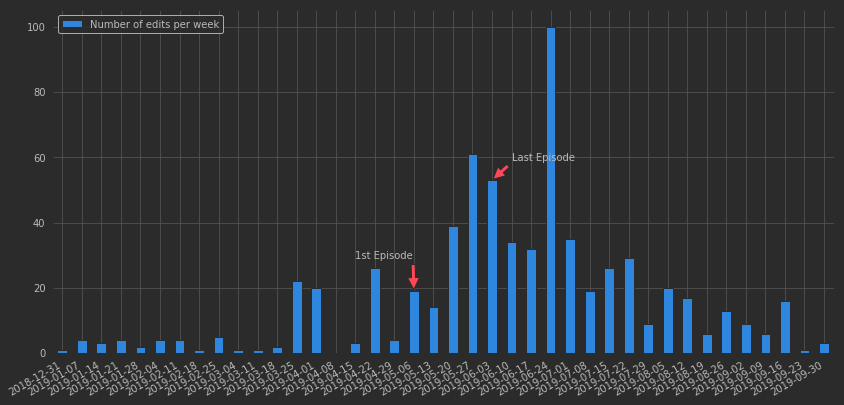

In [28]:
fig, ax = plt.subplots(figsize=(14, 7))
weekly_stats.plot(kind='bar', color=flatui_palette[0], ax=ax, label='Number of edits per week')

ax.set_xticklabels([x.strftime('%Y-%m-%d') for x in weekly_stats.index])
xpos = list(weekly_stats.index).index(MINISERIES_RELEASE_DATE)
ypos = weekly_stats[MINISERIES_RELEASE_DATE]

ax.annotate(
    '1st Episode', xy=(xpos, ypos), xytext=(xpos-3, ypos + 10),
    arrowprops=dict(facecolor=flatui_palette[1], shrink=0.05),
    #horizontalalignment='right', verticalalignment='top',
)

xpos = list(weekly_stats.index).index(MINISERIES_LAST_EPISODE_DATE)
ypos = weekly_stats[MINISERIES_LAST_EPISODE_DATE]
ax.annotate(
    'Last Episode', xy=(xpos, ypos), xytext=(xpos + 1, ypos + 6),
    arrowprops=dict(facecolor=flatui_palette[1], shrink=0.05),
    #horizontalalignment='right', verticalalignment='top',
)

fig.autofmt_xdate()
ax.legend(loc='upper left');

Clearly, the series had a deep impact in the number of editions of the wikipedia page.

### Analyzing Pageviews

The impact of the TV Show on the Wikipedia page was clearly significant, and it reflects some of the controversies introduced by the miniseries. Something else interesting to see are the visualizations of the pages

In [29]:
import urllib.parse

In [30]:
BASE_METRICS_URL = "https://wikimedia.org/api/rest_v1/metrics/"

In [31]:
agents = urllib.parse.urljoin(
    BASE_METRICS_URL,
    'pageviews/per-article/en.wikipedia/all-access/all-agents/', True)

In [32]:
PAGEVIEWS_START = pd.Timestamp('2019-01-01')
PAGEVIEWS_END = pd.Timestamp.now().replace(hour=0, minute=0, second=0, microsecond=0, nanosecond=0) - pd.Timedelta('1d')

In [33]:
url = urllib.parse.urljoin(
    agents,
    '{article}/daily/{start}/{end}'.format(
        article=urllib.parse.quote(page_title),
        start=PAGEVIEWS_START.strftime('%Y%m%d00'),
        end=PAGEVIEWS_END.strftime('%Y%m%d00')
    ))

In [34]:
resp = requests.get(url)

In [35]:
resp

<Response [200]>

In [36]:
doc = resp.json()

In [37]:
doc.keys()

dict_keys(['items'])

In [38]:
df = pd.DataFrame.from_records(doc['items'])

In [39]:
df.head(10)

,access,agent,article,granularity,project,timestamp,views
0,all-access,all-agents,Chernobyl_disaster,daily,en.wikipedia,2019010100,8204
1,all-access,all-agents,Chernobyl_disaster,daily,en.wikipedia,2019010200,8877
2,all-access,all-agents,Chernobyl_disaster,daily,en.wikipedia,2019010300,8733
3,all-access,all-agents,Chernobyl_disaster,daily,en.wikipedia,2019010400,10807
4,all-access,all-agents,Chernobyl_disaster,daily,en.wikipedia,2019010500,7453
5,all-access,all-agents,Chernobyl_disaster,daily,en.wikipedia,2019010600,7895
6,all-access,all-agents,Chernobyl_disaster,daily,en.wikipedia,2019010700,9198
7,all-access,all-agents,Chernobyl_disaster,daily,en.wikipedia,2019010800,8795
8,all-access,all-agents,Chernobyl_disaster,daily,en.wikipedia,2019010900,9176
9,all-access,all-agents,Chernobyl_disaster,daily,en.wikipedia,2019011000,8824


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 7 columns):
access         280 non-null object
agent          280 non-null object
article        280 non-null object
granularity    280 non-null object
project        280 non-null object
timestamp      280 non-null object
views          280 non-null int64
dtypes: int64(1), object(6)
memory usage: 15.4+ KB


In [41]:
df['timestamp'] = pd.to_datetime(df['timestamp'].str[:-2])

In [42]:
df.sort_values(by='timestamp', ascending=True, inplace=True)

In [43]:
df.set_index('timestamp', inplace=True)

In [44]:
df.index.is_monotonic_increasing

True

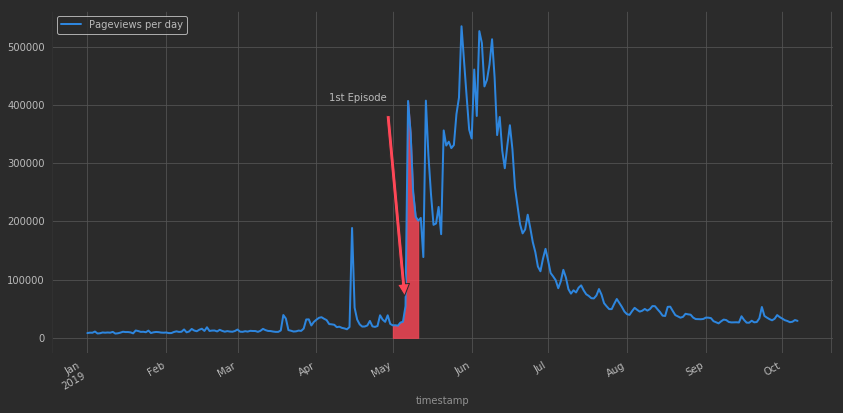

In [45]:
fig, ax = plt.subplots(figsize=(14, 7))

df['views'].plot(ax=ax, label='Pageviews per day', linewidth=2)

selected_views = df.loc[MINISERIES_RELEASE_DATE - pd.Timedelta('5d'): MINISERIES_RELEASE_DATE + pd.Timedelta('5d'), 'views']
ax.fill_between(selected_views.index, selected_views, color=flatui_palette[1], alpha=0.8)

'''
ax.bar([
    (MINISERIES_RELEASE_DATE + pd.Timedelta('%sd' % x)).to_pydatetime()
    for x in range(-5, 6)
], df.loc[MINISERIES_RELEASE_DATE - pd.Timedelta('5d'): MINISERIES_RELEASE_DATE + pd.Timedelta('5d'), 'views'].values, color='#ff000080')
'''

xpos = MINISERIES_RELEASE_DATE.to_pydatetime()
ypos = df.loc[MINISERIES_RELEASE_DATE, 'views']

xpos_text = (MINISERIES_RELEASE_DATE - pd.Timedelta('30d')).to_pydatetime()
ypos_text = df.loc[MINISERIES_RELEASE_DATE + pd.Timedelta('1d'), 'views']

ax.annotate(
    '1st Episode', xy=(xpos, ypos), xytext=(xpos_text, ypos_text),
    arrowprops=dict(facecolor=flatui_palette[1], shrink=0.05),
)

fig.autofmt_xdate()
ax.legend(loc='upper left');